<a href="https://colab.research.google.com/github/Hanoada/Hanoada/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/meteor_data.csv /content

Please Input a City Name: Logan
Please Input a State Abbreviation (i.e., 'CA' for California): UT
Please Select a Search Radius: 50
Epoch 1/100
10/10 [==============================] - 2s 37ms/step - loss: 47.9030 - accuracy: 0.7363 - binary_accuracy: 0.7326 - val_loss: 27.0477 - val_accuracy: 0.7015 - val_binary_accuracy: 0.7357
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 10.7006 - accuracy: 0.5498 - binary_accuracy: 0.7113 - val_loss: 4.2717 - val_accuracy: 0.2985 - val_binary_accuracy: 0.6128
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 4.1963 - accuracy: 0.2894 - binary_accuracy: 0.5527 - val_loss: 2.3679 - val_accuracy: 0.2985 - val_binary_accuracy: 0.5021
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 2.6077 - accuracy: 0.2797 - binary_accuracy: 0.4735 - val_loss: 2.0234 - val_accuracy: 0.7015 - val_binary_accuracy: 0.4705
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 2.2

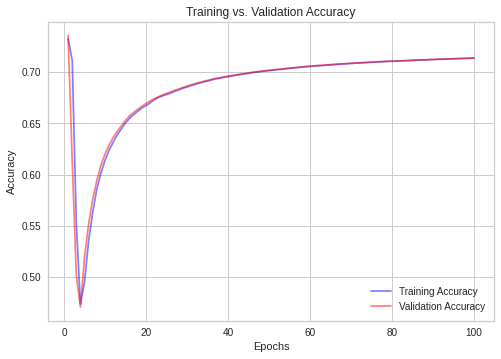

14/14 [==============================] - 0s 3ms/step - loss: 1.0889 - accuracy: 0.7258 - binary_accuracy: 0.7137


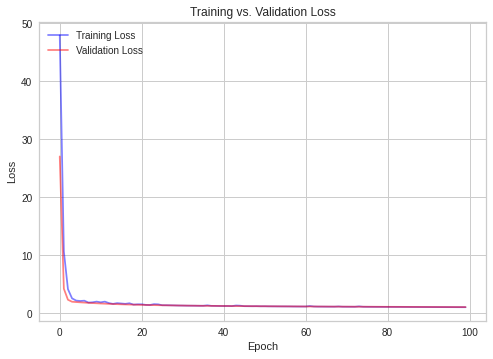

1/1 [==============================] - 0s 168ms/step


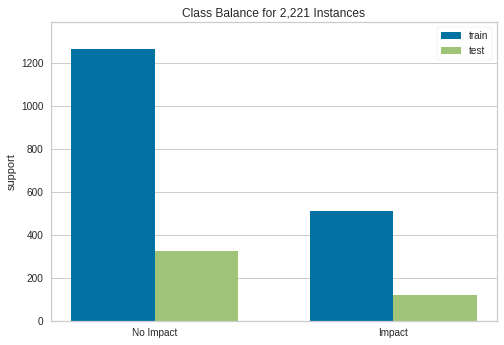

In [4]:
import geopy as geopy
import keras.backend as k
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.metrics import BinaryAccuracy
from yellowbrick import ClassBalance
from yellowbrick.features import ParallelCoordinates
import keras.layers.regularization
from geopy.distance import geodesic
from imblearn.over_sampling import SMOTE


# This line of code gathers the meteorite data set from the local environment and assembles it into a pandas DataFrame
# called "meteor_data". This is the DataFrame used throughout the code.
meteor_data = pd.read_csv("/content/drive/MyDrive/meteor_data.csv")


user_city = input("Please Input a City Name: ")
user_state = input("Please Input a State Abbreviation (i.e., 'CA' for California): ")
target_radius = int(input("Please Select a Search Radius: "))

# Use GeoPy GeoCoders to get the latitude and longitude coordinates for the user-input city and state.
user_location = (user_city + ', ' + user_state)
my_nom = geopy.geocoders.Nominatim(user_agent="myGeocoder")
location = my_nom.geocode(user_location)

# Parameterize user input to use throughout program.
user_lat = location.latitude
user_lon = location.longitude
target_point = (user_lat, user_lon)

# ***START DETERMINESEARCH***

# This function determines if there are at least 3 meteors within the initial search criteria. If not, it expands the
# search years and radius until it has at least 3 data points. These changes are taken into account later in the
# program.
def determineSearch(meteor_data, target_point, target_radius):
    meteor_data["in_target"] = ((target_radius >= meteor_data.apply(
        lambda row: geodesic(target_point, (row["latitude"], row["longitude"])).miles, axis=1)) &
                                (meteor_data["year"] >= 1973) & (meteor_data["year"] <= 2023))
    true_rows = meteor_data.loc[meteor_data['in_target']]

    while len(true_rows) <= 3:
        meteor_data["in_target"] = ((meteor_data.apply(
            lambda row: geodesic(target_point, (row["latitude"], row["longitude"])).miles, axis=1) <=
                                     target_radius + 25) & (meteor_data["year"] >= min(meteor_data["year"])))
        true_rows = meteor_data.loc[meteor_data['in_target']]
        target_radius = target_radius + 25

    return meteor_data, target_point, target_radius, true_rows

# ***END DETERMINESEARCH***

# ***START SMOTESAMPLER***

# This function is used to resample the extremely imbalanced data by creating synthetic data points. Depending on the
# number of meteor impacts within the user's original radius, it the function uses a different sampling strategy. The
# sampling strategies were created through trial-and-error to try and get higher accuracy in the model.
def overSample(true_rows, x, y):
    if len(true_rows) > 5:
        over_sample = SMOTE(random_state=42, sampling_strategy=0.30)
        X_resampled, y_resampled = over_sample.fit_resample(x, y)
    elif len(true_rows) == 5:
        over_sample = SMOTE(random_state=42, k_neighbors=4, sampling_strategy=0.40)
        X_resampled, y_resampled = over_sample.fit_resample(x, y)
    elif len(true_rows) == 4:
        over_sample = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=0.50)
        X_resampled, y_resampled = over_sample.fit_resample(x, y)
    else:
        # Safeguard... If the function completely fails, the program should exit because the data will not be resampled,
        # which will cause the program to exit in error.
        X_resampled = None
        y_resampled = None
        print("NO METEORS WITHIN DATA RANGE")
        exit(0)

    return X_resampled, y_resampled

# ***END SMOTESAMPLER***

# Call the "determineSearch()" function in the "DetermineSearch.py" file included with this program.
meteor_data, target_point, target_radius2, true_rows = determineSearch(meteor_data, target_point, target_radius)

# Create a function to determine the number of years spanned by the meteors within the user's search criteria.
years_spanned = max(true_rows['year']) - min(true_rows['year'])

# Create a list of feature names to use when using / splitting data and training the Neural Network.
feature_names = ['latitude', 'longitude', 'year']

# Load the meteor_data data set into a Pandas DataFrame object.
X = meteor_data[feature_names]
y = meteor_data['in_target']

# Use "overSample()" function in the "SMOTESampler.py" file included with this program to balance the data
# by creating synthetic test cases.
X_resampled, y_resampled = overSample(true_rows, X, y)

# Split the data set into training, validation, and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2,
                                                          random_state=42)

# Define the Neural Network architecture. I chose to include an input layer with 64 neurons, followed by a
# hidden layers of 8 neurons and an output layer of one neuron.
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.05), input_shape=[3]),
    keras.layers.Dropout(0.01),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    keras.layers.Dropout(0.01),
    keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary cross-entropy loss and Adam optimizer. Binary cross-entropy calculates the
# difference between the predicted output and true output and adjusts the model's biases to minimize the
# difference. The "Adam()" optimizer is a stochastic gradient descent optimization algorithm used in training
# deep neural networks. 0.001 is the learning rate, which determines the step size at which the optimizer
# updates the parameters while training.
# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy', BinaryAccuracy()])

# The test_input below is a NumPy array of the user-entered 'latitude' and 'longitude' as well as an entry for
# each year from 2024 to 2074 (25 years).
test_input = np.array([([user_lat, user_lon, 2024], [user_lat, user_lon, 2025], [user_lat, user_lon, 2026],
                       [user_lat, user_lon, 2027], [user_lat, user_lon, 2028], [user_lat, user_lon, 2029],
                       [user_lat, user_lon, 2030], [user_lat, user_lon, 2031], [user_lat, user_lon, 2032],
                       [user_lat, user_lon, 2033], [user_lat, user_lon, 2034], [user_lat, user_lon, 2035],
                       [user_lat, user_lon, 2036], [user_lat, user_lon, 2037], [user_lat, user_lon, 2038],
                       [user_lat, user_lon, 2039], [user_lat, user_lon, 2040], [user_lat, user_lon, 2041],
                       [user_lat, user_lon, 2042], [user_lat, user_lon, 2043], [user_lat, user_lon, 2044],
                       [user_lat, user_lon, 2045], [user_lat, user_lon, 2046], [user_lat, user_lon, 2047],
                       [user_lat, user_lon, 2048])])
# This line of code reshapes the data to fit the values above.
test_input = test_input.reshape((25, 3))

# The history code trains the neural network model using the "fit" method in Keras. Epochs is the number of
# times the model will iterate over the data set. 30% of the data is split for validation.
history = model.fit(X_test, y_test, epochs=100, validation_split=0.3, shuffle=True, verbose=1)

# Get the binary accuracy of the model. Used in the final prediction calculation. The epochs variable needs to
# be set as a range because the neural network may or may not actually iterate 100 times.
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy graph. The 'alpha' argument sets transparency level for the lines.
plt.plot(epochs, train_acc, '-', color='blue', label='Training Accuracy', alpha=0.5)
plt.plot(epochs, val_acc, '-', color='red', label='Validation Accuracy', alpha=0.5)
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the neural network on the test data.
test_results = model.evaluate(X_test, y_test)

# Plot the training & validation loss values.
plt.plot(history.history['loss'], color='blue', alpha=0.5, label='Training Loss')
plt.plot(history.history['val_loss'], color='red', alpha=0.5, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

# Make predictions on new data. This is pulling the test_input from above, which has 50 listed items, all of
# which have the user's latitude and longitude locations, but each have a different year to predict over a 50
# year timespan. Then, the predictions are averaged to get an overall percentage per year. This is used later
# to calculate the percentage in the next 25 year.
y_pred = model.predict(test_input, batch_size=25)
average_year_percent = y_pred.sum() / 25

# Calculate the probability percentage for 1 year. Used to calculate probability over 25 years.
percent_predict = 1 - (pow((1 - (float(average_year_percent / 100))), 25))

# Normalize the distance since the radius may have been changed to gather more data points.
normalized_radius = target_radius / target_radius2

# Normalize prediction with normalized radius and percentage. Used to account for radius change in case
# the user's location doesn't have meteors within the range criteria. See DetermineSearch.py for more info.
if target_radius2 > target_radius:
    normalized_prediction = normalized_radius * percent_predict
else:
    normalized_prediction = percent_predict

# Create class names for ParallelCoordinates visualization and instantiate visualizer.
classes = ['in-target', 'not in-target']
visualizer = ParallelCoordinates(classes=classes, features=feature_names, normalize='standard',
                                 shuffle=False, sample=0.5)
visualizer_CB = ClassBalance(labels=["No Impact", "Impact"])
visualizer_CB.fit(y_train, y_test)
visualizer_CB.show()

# Create parameter for final prediction. This puts the prediction in the correct format for GUI output, which
# will use a string formatter to output as a percentage to the user.
final_prediction = 100 * float(normalized_prediction)
